## 基于知识蒸馏的CNN手写数字识别模型压缩

### 数学背景


# Softmax,  log_softmax, NLLLoss and CrossEntropy

## What is Sofmax

**函数Softmax(x)**: 输入一个实数向量并返回一个概率分布。定义 x 是一个实数的向量(正数或负数都可以)。 然后, 第i个 Softmax(x) 的计算方式为：
$$\frac{{\exp ({x_i})}}{{\sum\nolimits_j {\exp ({x_j})} }}$$

输出是一个概率分布: 每个元素都是非负的, 并且所有元素的总和都是1

In [28]:
import torch
import torch.nn.functional as F

torch.manual_seed(0)

**在图片分类问题中，输入m张图片，输出一个m\*N的Tensor，其中N是分类类别总数。比如输入2张图片，分三类，最后的输出是一个2*3的Tensor，举个例子：**

In [29]:
output = torch.randn(2, 3)
print(output)

tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986]])


第1,2行分别是第1,2张图片的结果，假设第123列分别是猫、狗和猪的分类得分。

可以看出模型认为两张都更可能是猫。
然后对每一行使用Softmax，这样可以得到每张图片的概率分布。

In [30]:
print(F.softmax(output, dim=1))
# 这里dim的意思是计算Softmax的维度，这里设置dim=1，可以看到每一行的加和为1。

tensor([[0.8446, 0.1349, 0.0205],
        [0.7511, 0.1438, 0.1051]])


## What is log_softmax

这个很好理解，其实就是对softmax处理之后的结果执行一次对数运算。

可以理解为 log(softmax(output))

In [31]:
print(F.log_softmax(output, dim=1))
print(torch.log(F.softmax(output, dim=1)))
# 输出结果是一致的

tensor([[-0.1689, -2.0033, -3.8886],
        [-0.2862, -1.9392, -2.2532]])
tensor([[-0.1689, -2.0033, -3.8886],
        [-0.2862, -1.9392, -2.2532]])


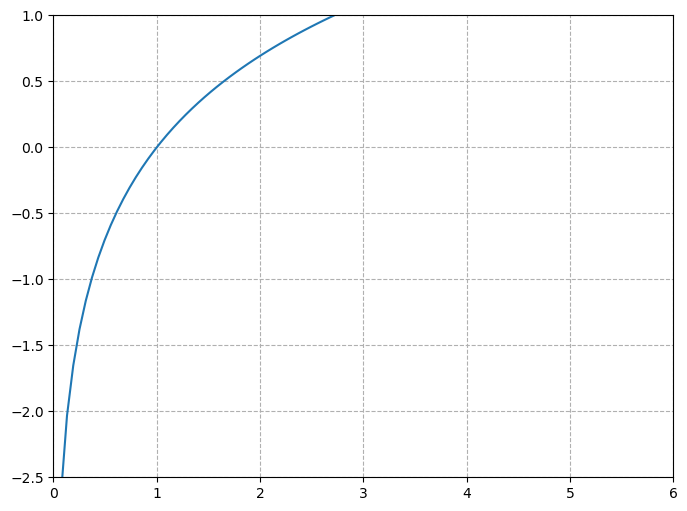

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# 创建x和y数据
x = np.linspace(0.01, 6, 100) # 将起始值改为0.01,避免除零错误
y = np.log(x)

# 设置图像大小
plt.figure(figsize=(8, 6))

# 绘制曲线
plt.plot(x, y)

# 设置x轴和y轴范围
plt.xlim(0, 6)
plt.ylim(-2.5, 1)

# 设置坐标轴刻度
plt.xticks(np.arange(0, 7, 1))
plt.yticks(np.arange(-2.5, 1.5, 0.5))

# 显示网格
plt.grid(linestyle='--')

# 显示图像
plt.show()

## What is NLLLoss？

该函数的全称是negative log likelihood loss. 若$x_i=[q_1, q_2, ..., q_N]$ 为神经网络对第i个样本的输出值，$y_i$为真实标签。则：
$$f(x_i,y_i)=-q_{y_i}$$

输入：log_softmax(output), target

In [33]:
print(F.nll_loss(torch.tensor([[-1.2, -2, -3]]), torch.tensor([0])))

tensor(1.2000)


### 通常我们结合 log_softmax 和 nll_loss一起用

In [34]:
output = torch.tensor([[1.2, 2, 3]])

target = torch.tensor([0])
log_sm_output = F.log_softmax(output, dim=1)
print('Output is [1.2, 2, 3]. If the target is 0, loss is:', F.nll_loss(log_sm_output, target))

target = torch.tensor([1])
log_sm_output = F.log_softmax(output, dim=1)
print('Output is [1.2, 2, 3]. If the target is 1, loss is:', F.nll_loss(log_sm_output, target))

target = torch.tensor([2])
log_sm_output = F.log_softmax(output, dim=1)
print('Output is [1.2, 2, 3]. If the target is 2, loss is:', F.nll_loss(log_sm_output, target))

Output is [1.2, 2, 3]. If the target is 0, loss is: tensor(2.2273)
Output is [1.2, 2, 3]. If the target is 1, loss is: tensor(1.4273)
Output is [1.2, 2, 3]. If the target is 2, loss is: tensor(0.4273)


##  在分类问题中，CrossEntropy等价于log_softmax 结合 nll_loss

$N$分类问题，对于一个特定的样本，已知其真实标签，CrossEntropy的计算公式为：

$$cross\_entropy=-\sum_{k=1}^{N}\left(p_{k} * \log q_{k}\right)$$

其中p表示真实值，在这个公式中是one-hot形式；**q是经过softmax计算后的结果， $q_k$为神经网络认为该样本为第$k$类的概率。**

仔细观察可以知道，因为p的元素不是0就是1，而且又是乘法，所以很自然地我们如果知道1所对应的index，那么就不用做其他无意义的运算了。所以在pytorch代码中target不是以one-hot形式表示的，而是直接用scalar表示。若该样本的真实标签为$y$,则交叉熵的公式可变形为：

$$cross\_entropy=-\sum_{k=1}^{N}\left(p_{k} * \log q_{k}\right)=-log \, q_{y}$$

In [35]:
output = torch.tensor([[1.2, 2, 3]])
target = torch.tensor([0])

log_sm_output = F.log_softmax(output, dim=1)
nll_loss_of_log_sm_output = F.nll_loss(log_sm_output, target)
print(nll_loss_of_log_sm_output)

tensor(2.2273)


More about softmax：同一个输出向量（分类得分），通过不同温度的蒸馏，得到激进平滑不同状态的输出

[0.02590865 0.11611453 0.85797681]
[0.22916797 0.3093444  0.46148762]
[0.33327778 0.33332777 0.33339445]


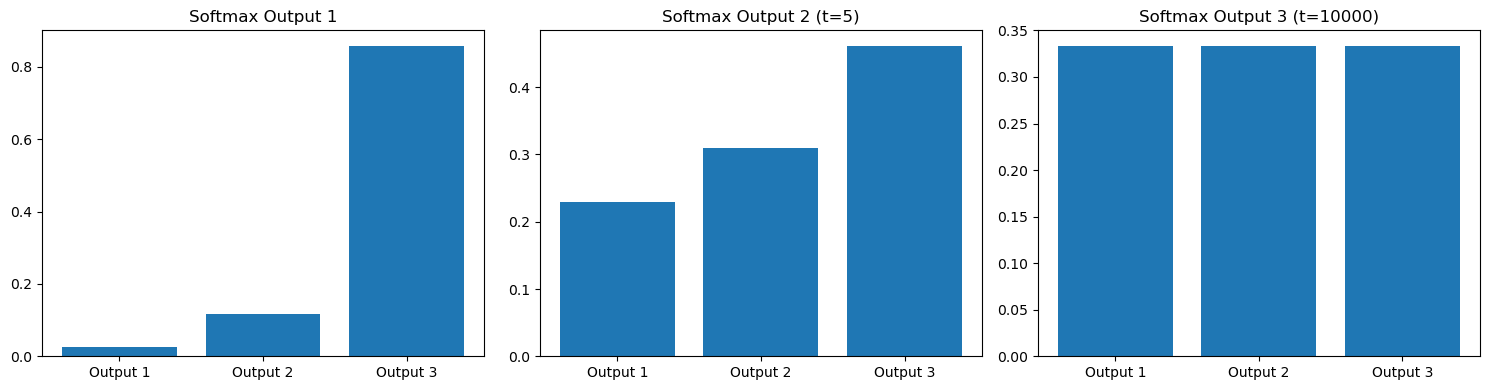

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):#定义一个普通的softmax函数
    x_exp = np.exp(x)
    return x_exp / np.sum(x_exp)

def softmax_t(x, t):#定义一个带有温度参数的softmax函数
    x_exp = np.exp(x / t)
    return x_exp / np.sum(x_exp)

output = np.array([0.1, 1.6, 3.6])#定义一个输出向量

softmax_output1 = softmax(output)
softmax_output2 = softmax_t(output, 5)
softmax_output3 = softmax_t(output, 10000)

print(softmax_output1)
print(softmax_output2)
print(softmax_output3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

axes[0].bar(range(len(softmax_output1)), softmax_output1)
axes[0].set_xticks(range(len(softmax_output1)))
axes[0].set_xticklabels(['Output 1', 'Output 2', 'Output 3'])
axes[0].set_title('Softmax Output 1')

axes[1].bar(range(len(softmax_output2)), softmax_output2)
axes[1].set_xticks(range(len(softmax_output2)))
axes[1].set_xticklabels(['Output 1', 'Output 2', 'Output 3'])
axes[1].set_title('Softmax Output 2 (t=5)')

axes[2].bar(range(len(softmax_output3)), softmax_output3)
axes[2].set_xticks(range(len(softmax_output3)))
axes[2].set_xticklabels(['Output 1', 'Output 2', 'Output 3'])
axes[2].set_title('Softmax Output 3 (t=10000)')

plt.tight_layout()
plt.show()

[0.02590865 0.11611453 0.85797681]
[0.22916797 0.3093444  0.46148762]
[0.33327778 0.33332777 0.33339445]


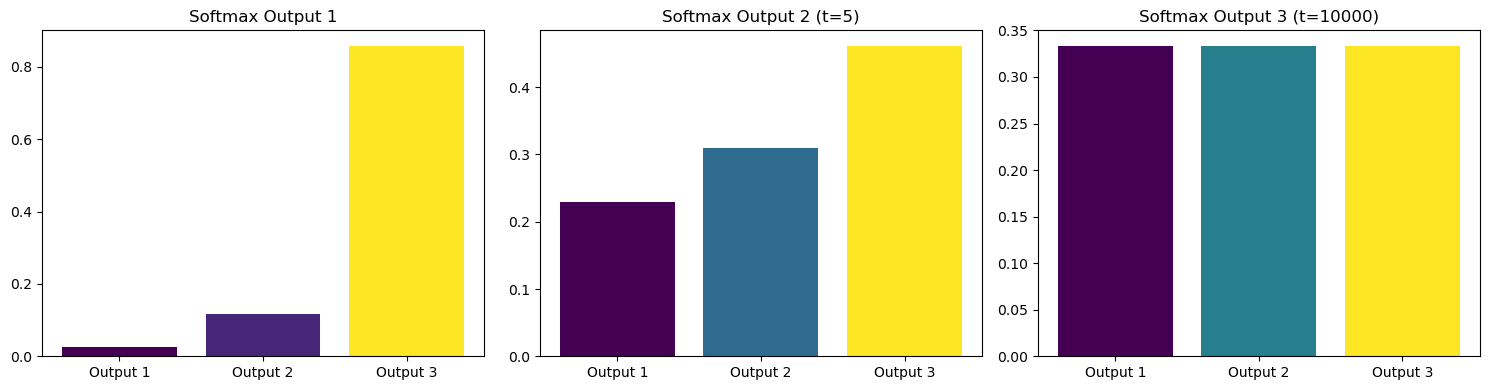

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def softmax(x):
    x_exp = np.exp(x)
    return x_exp / np.sum(x_exp)

def softmax_t(x, t):
    x_exp = np.exp(x / t)
    return x_exp / np.sum(x_exp)

output = np.array([0.1, 1.6, 3.6])

softmax_output1 = softmax(output)
softmax_output2 = softmax_t(output, 5)
softmax_output3 = softmax_t(output, 10000)

print(softmax_output1)
print(softmax_output2)
print(softmax_output3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Use the updated method to get a colormap
colormap = plt.colormaps['viridis']

# Normalize the data for color mapping
norm1 = mcolors.Normalize(vmin=min(softmax_output1), vmax=max(softmax_output1))
norm2 = mcolors.Normalize(vmin=min(softmax_output2), vmax=max(softmax_output2))
norm3 = mcolors.Normalize(vmin=min(softmax_output3), vmax=max(softmax_output3))

bars1 = axes[0].bar(range(len(softmax_output1)), softmax_output1, color=colormap(norm1(softmax_output1)))
axes[0].set_xticks(range(len(softmax_output1)))
axes[0].set_xticklabels(['Output 1', 'Output 2', 'Output 3'])
axes[0].set_title('Softmax Output 1')

bars2 = axes[1].bar(range(len(softmax_output2)), softmax_output2, color=colormap(norm2(softmax_output2)))
axes[1].set_xticks(range(len(softmax_output2)))
axes[1].set_xticklabels(['Output 1', 'Output 2', 'Output 3'])
axes[1].set_title('Softmax Output 2 (t=5)')

bars3 = axes[2].bar(range(len(softmax_output3)), softmax_output3, color=colormap(norm3(softmax_output3)))
axes[2].set_xticks(range(len(softmax_output3)))
axes[2].set_xticklabels(['Output 1', 'Output 2', 'Output 3'])
axes[2].set_title('Softmax Output 3 (t=10000)')

plt.tight_layout()
plt.show()

[0.02590865 0.11611453 0.85797681]
[0.22916797 0.3093444  0.46148762]
[0.33327778 0.33332777 0.33339445]


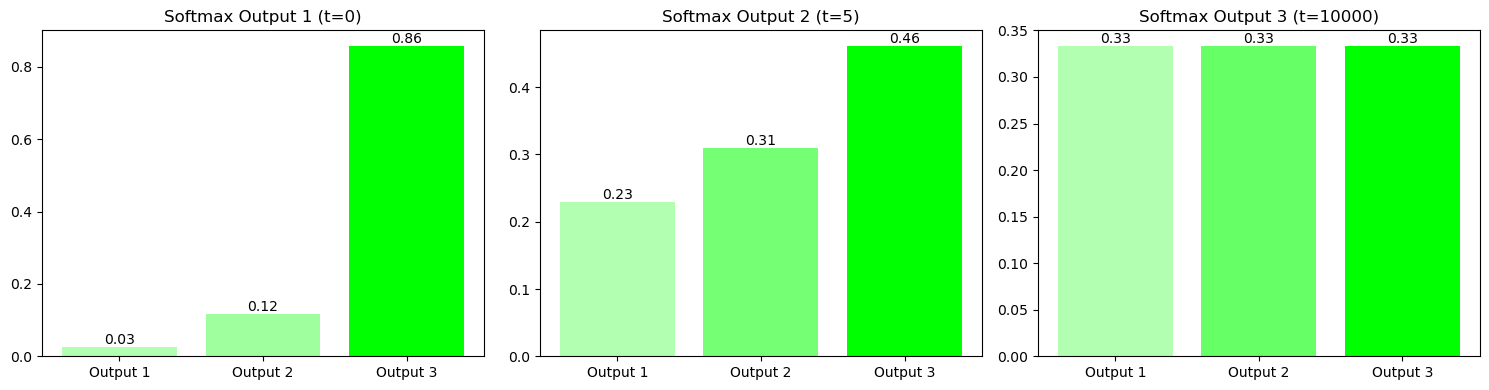

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def softmax(x):
    x_exp = np.exp(x)
    return x_exp / np.sum(x_exp)

def softmax_t(x, t):
    x_exp = np.exp(x / t)
    return x_exp / np.sum(x_exp)

output = np.array([0.1, 1.6, 3.6])#神经网络最后几层，输出的分类得分

softmax_output1 = softmax(output)
softmax_output2 = softmax_t(output, 5)
softmax_output3 = softmax_t(output, 10000)

print(softmax_output1)
print(softmax_output2)
print(softmax_output3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Normalize the data for alpha mapping
norm1 = mcolors.Normalize(vmin=min(softmax_output1), vmax=max(softmax_output1))
norm2 = mcolors.Normalize(vmin=min(softmax_output2), vmax=max(softmax_output2))
norm3 = mcolors.Normalize(vmin=min(softmax_output3), vmax=max(softmax_output3))

def create_bars(ax, data, norm, title):
    base_color = np.array([0, 1, 0])  # choose color in RGB
    min_alpha = 0.3  # Minimum alpha value
    max_alpha = 1.0  # Maximum alpha value
    bars = ax.bar(range(len(data)), data, color=[(base_color[0], base_color[1], base_color[2], min_alpha + (max_alpha - min_alpha) * norm(value)) for value in data])
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels(['Output 1', 'Output 2', 'Output 3'])
    ax.set_title(title)
    # Add value labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', color='black')
    return bars

bars1 = create_bars(axes[0], softmax_output1, norm1, 'Softmax Output 1 (t=0)')
bars2 = create_bars(axes[1], softmax_output2, norm2, 'Softmax Output 2 (t=5)')
bars3 = create_bars(axes[2], softmax_output3, norm3, 'Softmax Output 3 (t=10000)')

plt.tight_layout()
plt.show()


### 正式开始手写识别网络的知识蒸馏任务

问题描述  
卷积神经网络(CNN)在手写数字识别等图像分类任务中表现出色,但通常需要大量参数,导致计算和存储资源的浪费。  
模型压缩技术旨在减少模型的大小和计算复杂度,而不会过多牺牲性能。  
知识蒸馏是一种有效的模型压缩方法,通过将一个大型高性能教师模型的知识迁移到一个小型学生模型中,从而在减小模型尺寸的同时尽可能保留教师模型的性能。  
本实验将采用知识蒸馏技术对手写数字识别CNN模型进行压缩。

数据集描述  
实验使用MNIST手写数字数据集,包括60,000个训练图像和10,000个测试图像。每张图像是28x28像素的灰度手写数字图像,标签为0到9之间的数字。

In [39]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data


torch.manual_seed(0)
torch.cuda.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [40]:
class TeacherNet(nn.Module):
   def __init__(self):
       super(TeacherNet, self).__init__()
       # 第一个卷积层，输入通道数为1（灰度图像），输出通道数为32，卷积核大小为3x3，步长为1
       self.conv1 = nn.Conv2d(1, 32, 3, 1)  
       # 第二个卷积层，输入通道数为32，输出通道数为64，卷积核大小为3x3，步长为1
       self.conv2 = nn.Conv2d(32, 64, 3, 1)
       # 第一个dropout层，dropout概率为0.3
       self.dropout1 = nn.Dropout2d(0.3)
       # 第二个dropout层，dropout概率为0.5
       self.dropout2 = nn.Dropout2d(0.5)
       # 第一个全连接层，输入维度为9216（64 * 7 * 7），输出维度为128
       self.fc1 = nn.Linear(9216, 128)
       # 第二个全连接层，输入维度为128，输出维度为10（对应0-9的数字）
       self.fc2 = nn.Linear(128, 10)

   def forward(self, x):
       # 卷积 -> ReLU激活
       x = self.conv1(x)
       x = F.relu(x)
       # 卷积 -> ReLU激活
       x = self.conv2(x)
       x = F.relu(x)
       # 最大池化，核大小为2
       x = F.max_pool2d(x, 2)
       # 第一个dropout层
       x = self.dropout1(x)
       # 将输出拉平成一维向量
       x = torch.flatten(x, 1)
       # 第一个全连接层 -> ReLU激活
       x = self.fc1(x)
       x = F.relu(x)
       # 第二个dropout层
       x = self.dropout2(x)
       # 第二个全连接层，输出为10个数字的概率分布
       output = self.fc2(x)
       return output

TeacherNet网络结构不是一个多层感知机(MLP),而是一个卷积神经网络(CNN)。

解释如下:

1. 网络包含两个卷积层(nn.Conv2d),用于从输入图像中提取特征。这是CNN的典型结构,而MLP通常只包含全连接层。

2. 在卷积层之后,使用了ReLU激活函数和最大池化层(F.max_pool2d),这也是CNN常用的操作,用于增加网络的非线性和平移不变性。

3. 网络中有两个dropout层(nn.Dropout2d),用于防止过拟合,这在CNN中也很常见。

4. 在卷积层和池化层之后,输出张量被拉平(torch.flatten)以输入到全连接层(nn.Linear)中。这种卷积层和全连接层的组合结构是CNN的典型设计。

5. 最后一层是一个具有10个输出单元的全连接层(self.fc2),通常用于对MNIST等10类图像数据进行分类。

综上所述,虽然该网络包含全连接层,但由于包含了卷积层、池化层等特征提取层,因此它属于CNN的范畴,而不是传统的只包含全连接层的MLP。CNN通常用于处理图像或其他结构化数据输入。

In [41]:
import torch
import torch.nn.functional as F
import math

def train_teacher(model, device, train_loader, optimizer, epoch):
    """
    训练教师模型的函数。

    参数:
    - model: 待训练的神经网络模型
    - device: 训练设备 (如 'cuda' 或 'cpu')
    - train_loader: 包含训练数据的 DataLoader
    - optimizer: 用于优化模型的优化器
    - epoch: 当前的训练周期数
    """
    model.train()  # 设置模型为训练模式
    trained_samples = 0  # 初始化已训练样本计数
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # 将数据和标签转移到指定设备
        optimizer.zero_grad()  # 梯度清零
        output = model(data)  # 前向传播
        loss = F.cross_entropy(output, target)  # 计算交叉熵损失
        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 更新模型参数

        trained_samples += len(data)  # 更新已训练样本数
        progress = math.ceil(batch_idx / len(train_loader) * 50)  # 计算训练进度
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')  # 打印训练进度


def test_teacher(model, device, test_loader):
    """
    测试教师模型的函数。

    参数:
    - model: 待测试的神经网络模型
    - device: 测试设备 (如 'cuda' 或 'cpu')
    - test_loader: 包含测试数据的 DataLoader

    返回:
    - test_loss: 平均测试损失
    - accuracy: 测试集上的准确率
    """
    model.eval()  # 设置模型为评估模式
    test_loss = 0  # 初始化测试损失
    correct = 0  # 初始化正确预测计数
    with torch.no_grad():  # 禁用梯度计算
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # 将数据和标签转移到指定设备
            output = model(data)  # 前向传播
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # 累加批次损失
            pred = output.argmax(dim=1, keepdim=True)  # 获取概率最高的预测类别
            correct += pred.eq(target.view_as(pred)).sum().item()  # 统计正确预测的数量

    test_loss /= len(test_loader.dataset)  # 计算平均测试损失

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))  # 打印测试结果
    return test_loss, correct / len(test_loader.dataset)  # 返回测试损失和准确率



In [42]:
def teacher_main():
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = TeacherNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    teacher_history = []

    for epoch in range(1, epochs + 1):
        train_teacher(model, device, train_loader, optimizer, epoch)
        loss, acc = test_teacher(model, device, test_loader)
        
        teacher_history.append((loss, acc))

    torch.save(model.state_dict(), "teacher.pt")
    return model, teacher_history

In [43]:
# 训练教师网络
teacher_model, teacher_history = teacher_main()

E:\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0464, accuracy: 9841/10000 (98%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0379, accuracy: 9871/10000 (99%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0331, accuracy: 9893/10000 (99%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0327, accuracy: 9896/10000 (99%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0341, accuracy: 9900/10000 (99%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0343, accuracy: 9900/10000 (99%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0319, accuracy: 9894/10000 (99%)
Train 

## 小插曲，看看老师的暗知识 

 ![image.png](kn2.png)  
 [0.7, 0.29, 0.01]就是蒸馏出来的暗知识

In [44]:
import numpy as np
from matplotlib import pyplot as plt

def softmax_t(x, t):
    x_exp = np.exp(x / t)
    return x_exp / np.sum(x_exp)

test_loader_bs1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=1, shuffle=True)

Output (NO softmax): [-18.85864   -18.727133  -18.11853   -19.461115  -25.552353  -23.339464
 -30.249464    1.8710859 -26.334263  -16.211397 ]


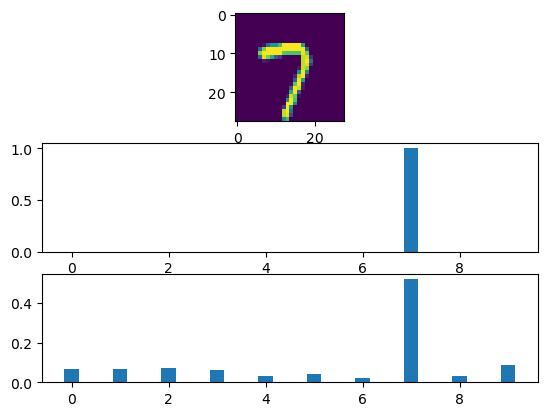

In [45]:
teacher_model.eval()
with torch.no_grad():
    data, target = next(iter(test_loader_bs1))
    data, target = data.to('cuda'), target.to('cuda')
    output = teacher_model(data)

test_x = data.cpu().numpy()
y_out = output.cpu().numpy()
y_out = y_out[0, ::]
print('Output (NO softmax):', y_out)

plt.subplot(3, 1, 1)
plt.imshow(test_x[0, 0, ::])

plt.subplot(3, 1, 2)
plt.bar(list(range(10)), softmax_t(y_out, 1), width=0.3)

plt.subplot(3, 1, 3)
plt.bar(list(range(10)), softmax_t(y_out, 10), width=0.3)
plt.show()

是否加入蒸馏，输出的分类概率不同  
不加入蒸馏，让强大的老师网络分类图片，参数激进，识别效果非常明确  
加入蒸馏，老师网络保留了一定的暗知识，参数更加平滑，识别效果带有提醒作用

# 让老师教学生网络 （传授暗知识）

学生网络先天性比教师网络结构简单、参数少

In [46]:
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = F.relu(self.fc3(x))
        return output

### 关键，定义kd的loss 

In [47]:
def distillation(y, labels, teacher_scores, temp, alpha):
    return nn.KLDivLoss()(F.log_softmax(y / temp, dim=1), F.softmax(teacher_scores / temp, dim=1)) * (
            temp * temp * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)


In [48]:
def train_student_kd(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        teacher_output = teacher_model(data)
        teacher_output = teacher_output.detach()  # 切断老师网络的反向传播
        loss = distillation(output, target, teacher_output, temp=5.0, alpha=0.7)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_student_kd(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [49]:
def student_kd_main():
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = StudentNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    student_history = []
    for epoch in range(1, epochs + 1):
        train_student_kd(model, device, train_loader, optimizer, epoch)
        loss, acc = test_student_kd(model, device, test_loader)
        student_history.append((loss, acc))

    torch.save(model.state_dict(), "student_kd.pt")
    return model, student_history

In [50]:
student_kd_model, student_kd_history = student_kd_main()

E:\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1517, accuracy: 9679/10000 (97%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1283, accuracy: 9723/10000 (97%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0909, accuracy: 9804/10000 (98%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0857, accuracy: 9801/10000 (98%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0674, accuracy: 9834/10000 (98%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0759, accuracy: 9826/10000 (98%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0672, accuracy: 9839/10000 (98%)
Train 

In [51]:
## 让学生自己学，不使用KD
def train_student(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_student(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [52]:
def student_main():
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = StudentNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    student_history = []
    
    for epoch in range(1, epochs + 1):
        train_student(model, device, train_loader, optimizer, epoch)
        loss, acc = test_student(model, device, test_loader)
        student_history.append((loss, acc))

    torch.save(model.state_dict(), "student.pt")
    return model, student_history

In [53]:
student_simple_model, student_simple_history = student_main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1225, accuracy: 9620/10000 (96%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0963, accuracy: 9721/10000 (97%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0950, accuracy: 9740/10000 (97%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1005, accuracy: 9757/10000 (98%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0832, accuracy: 9807/10000 (98%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1079, accuracy: 9786/10000 (98%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1027, accuracy: 9791/10000 (98%)
Train 

In [54]:
import matplotlib.pyplot as plt

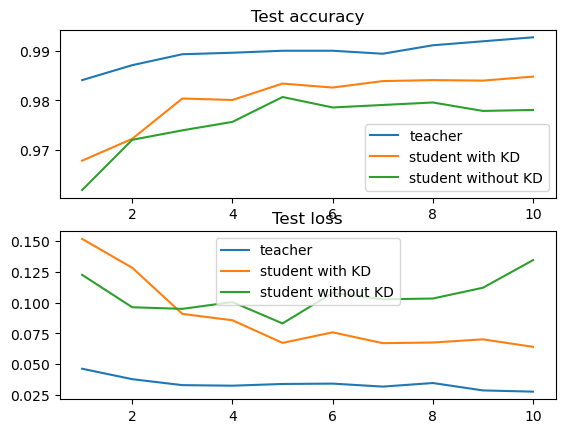

In [55]:
epochs = 10
x = list(range(1, epochs+1))

plt.subplot(2, 1, 1)
plt.plot(x, [teacher_history[i][1] for i in range(epochs)], label='teacher')
plt.plot(x, [student_kd_history[i][1] for i in range(epochs)], label='student with KD')
plt.plot(x, [student_simple_history[i][1] for i in range(epochs)], label='student without KD')

plt.title('Test accuracy')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(x, [teacher_history[i][0] for i in range(epochs)], label='teacher')
plt.plot(x, [student_kd_history[i][0] for i in range(epochs)], label='student with KD')
plt.plot(x, [student_simple_history[i][0] for i in range(epochs)], label='student without KD')

plt.title('Test loss')
plt.legend()




![image.png](kn1.png)  
知识蒸馏通常用于模型压缩，用一个已经训练好的模型A去“教”另外一个模型B。  
这两个模型称为老师-学生模型。  
通常模型A比模型B更强。在模型A的帮助下，模型B可以突破自我，学得更好。